In [2]:
import yfinance as yf
import pandas as pd
import json

# Download the option chain name that has atleast
# six months expiry and save them as json file

ticker = '^SPX'
stock = yf.Ticker(ticker)

expirations = stock.options

exp_date = '2025-12-19'

option_chain_24 = stock.option_chain(exp_date)
calls_24 = option_chain_24.calls
puts_24 = option_chain_24.puts

exp_date = '2026-01-16'
option_chain_25 = stock.option_chain(exp_date)
calls_25 = option_chain_25.calls
puts_25 = option_chain_25.puts


puts_24["lastTradeDate"] = puts_24["lastTradeDate"].apply(lambda x: str(x))
puts_25["lastTradeDate"] = puts_25["lastTradeDate"].apply(lambda x: str(x))

calls_24["lastTradeDate"] = calls_24["lastTradeDate"].apply(lambda x: str(x))
calls_25["lastTradeDate"] = calls_25["lastTradeDate"].apply(lambda x: str(x))


data_to_save = {
    'calls_24': calls_24.to_dict(),
    'puts_24': puts_24.to_dict(),
    'calls_25': calls_25.to_dict(),
    'puts_25': puts_25.to_dict()
}


with open('options_data.json', 'w') as f:
    json.dump(data_to_save, f)



In [3]:
# retrieve the option chain data from the json file
with open('options_data.json', 'r') as f:
    options_data = json.load(f)

calls_24 = pd.DataFrame(options_data['calls_24'])
puts_24 = pd.DataFrame(options_data['puts_24'])
calls_25 = pd.DataFrame(options_data['calls_25'])
puts_25 = pd.DataFrame(options_data['puts_25'])

calls_list_24 = calls_24.contractSymbol.apply(lambda x: x.replace('251219', '241220')).to_list()
puts_list_24 = puts_24.contractSymbol.apply(lambda x: x.replace('251219', '241220')).to_list()

calls_list_25 = calls_25.contractSymbol.apply(lambda x: x.replace('260116', '250117')).to_list()
puts_list_25 = puts_25.contractSymbol.apply(lambda x: x.replace('260116', '250117')).to_list()

In [4]:
# Download the data from polygon.io 
# for calls and puts the data download
#  is Jan 16, 2025 and Dec 20, 2025

import requests

maturity_24 = '2024-12-20'
maturity_25 = '2025-01-17'

api_key = 'rlXH7MruuBFDdYfs_w01S_uEw0jGwz76'

def get_data(chain_list, type="calls", maturity='2025-01-17'):

    df = pd.DataFrame()

    i = 0

    df = pd.DataFrame()
    n = len(chain_list)
    failed_list = []

    six_months_earlier = (pd.to_datetime(maturity) - pd.DateOffset(months=6)).\
        strftime('%Y-%m-%d')
    
    next_day = (pd.to_datetime(maturity) + pd.DateOffset(days=1)).strftime('%Y-%m-%d')


    for c in chain_list:
        
        i += 1
        print(f'{i}/{n}')

        url = 'https://api.polygon.io/v2/aggs/ticker/O:' + c + \
        '/range/1/day/' + str(six_months_earlier) + '/' \
        + str(next_day) + '?adjusted=true&sort=asc' + \
        '&apiKey=' + api_key

        response = requests.get(url)
        
        if response.status_code == 200:
            data = response.json()
            if 'results' in data:
                result = pd.DataFrame(data['results']).set_index('t')
                result.index = pd.to_datetime(result.index, unit='ms').strftime('%Y-%m-%d')
                result.rename(columns={'c': c}, inplace=True)
                result = result[c]
                df = pd.concat([df, result], axis=1)
            else:
                failed_list.append(c)
                
    df.index.name = 'Date'

    df.to_csv(f'{type}-{maturity}.csv')
    return failed_list

## Save the data to csv file 
## run only once to save

# failed_call_24 = get_data(calls_list_24, type="calls", maturity=maturity_24)
# failed_put_24 = get_data(puts_list_24, type="puts", maturity=maturity_24)

# failed_call_25 = get_data(calls_list_25, type="calls", maturity=maturity_25)
# failed_put_25 = get_data(puts_list_25, type="puts", maturity=maturity_25)

In [5]:
import numpy as np


# function to convert the option chaint to strike price
def get_strike_price(option_df, cols, rep1="241220", rep2="251219"):
    new_df = pd.DataFrame({
        'contractSymbol' : list(map(lambda x: x.replace(rep1, rep2), cols)),
        'counterpart' : cols
    }).set_index('contractSymbol')
    df = option_df.copy()
    df.set_index('contractSymbol', inplace=True)
    df = pd.concat([new_df, df], axis=1)
    df.dropna(subset=['counterpart'], inplace=True)
    return df["strike"]

######## Load the data from the csv file #######


calls_df_24 = pd.read_csv('calls-2024-12-20.csv').set_index('Date').sort_index()
calls_df_24.index = pd.to_datetime(calls_df_24.index)

# calls_df_24.ffill(inplace=True)

calls_df_24.columns = get_strike_price(calls_24, calls_df_24.columns, rep1="241220", rep2="251219").to_list()

######## Download the SPX and IRX data ########

start_date = str((calls_df_24.index[0] + pd.Timedelta(days=-2)).strftime('%Y-%m-%d'))
end_date   = str((calls_df_24.index[-1] + pd.Timedelta(days=2)).strftime('%Y-%m-%d'))

tickers = ['^SPX', '^IRX']

asset_data = yf.download( tickers, start=start_date, end=end_date)['Close']
asset_data.index = pd.to_datetime(asset_data.index)


print(asset_data.iloc[0])

# asset_data = asset_data.shift(-1)


calls_df_24 = calls_df_24.join(asset_data, how='left')
calls_df_24

[*********************100%***********************]  2 of 2 completed

Ticker
^IRX       5.235000
^SPX    5487.029785
Name: 2024-06-18 00:00:00, dtype: float64


,200.0,400.0,500.0,600.0,800.0,1000.0,1400.0,1600.0,1800.0,2000.0,...,8200.0,8400.0,8600.0,8800.0,9000.0,9200.0,9400.0,10000.0,^IRX,^SPX
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-20,NaN,NaN,NaN,NaN,NaN,4498.40,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.10,NaN,NaN,5.225,5473.169922
2024-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.10,NaN,NaN,5.215,5464.620117
2024-06-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,5.210,5447.870117
2024-06-25,5245.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,5.223,5469.299805
2024-06-26,NaN,NaN,NaN,NaN,NaN,4478.63,NaN,NaN,NaN,3500.6,...,0.15,0.15,0.1,0.05,0.05,0.05,NaN,NaN,5.230,5477.899902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-13,5838.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4065.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.218,6051.089844
2024-12-16,5884.00,NaN,NaN,NaN,NaN,5076.45,NaN,NaN,NaN,4068.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,4.228,6074.080078
2024-12-17,5849.96,5648.94,NaN,5450.01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.240,6050.609863


In [6]:
# Filter near ATM options and drop columns 
# with too many NaN values

S0 = calls_df_24["^SPX"].iloc[0]

filter = (calls_df_24.columns[:-2] < S0*1.02) & (calls_df_24.columns[:-2] > S0*0.80)


filter = np.append(filter, [True, True])

final_df = calls_df_24.loc[:, filter]


# Calculate the number of NaN values in each column
nan_counts = final_df.isna().sum()

# Get the top 70 columns with the most NaN values
top_nan_columns = nan_counts.nlargest(10).index

# Drop these columns from the dataframe
final_df = final_df.drop(columns=top_nan_columns)

final_df.head()

,4400.0,4500.0,4600.0,4700.0,4800.0,4850.0,4900.0,4950.0,4975.0,5000.0,...,5400.0,5425.0,5450.0,5475.0,5500.0,5525.0,5550.0,5575.0,^IRX,^SPX
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-20,1216.00,1098.98,NaN,NaN,NaN,806.9,740.62,NaN,NaN,656.25,...,348.90,344.31,313.36,NaN,272.73,256.68,237.06,236.6,5.225,5473.169922
2024-06-21,NaN,1098.06,1005.61,NaN,827.30,NaN,733.23,NaN,NaN,643.92,...,327.37,NaN,292.88,279.10,260.00,247.10,NaN,NaN,5.215,5464.620117
2024-06-24,1204.36,1096.42,NaN,NaN,809.60,NaN,NaN,NaN,660.39,640.45,...,315.20,322.50,288.10,271.39,255.21,NaN,NaN,NaN,5.210,5447.870117
2024-06-25,NaN,1085.57,986.95,905.74,818.81,NaN,734.88,671.65,NaN,643.99,...,327.26,307.60,287.86,265.20,260.93,239.75,NaN,NaN,5.223,5469.299805
2024-06-26,NaN,1089.07,NaN,NaN,818.50,NaN,NaN,NaN,NaN,646.08,...,326.69,NaN,293.28,272.80,257.66,NaN,226.28,207.8,5.230,5477.899902


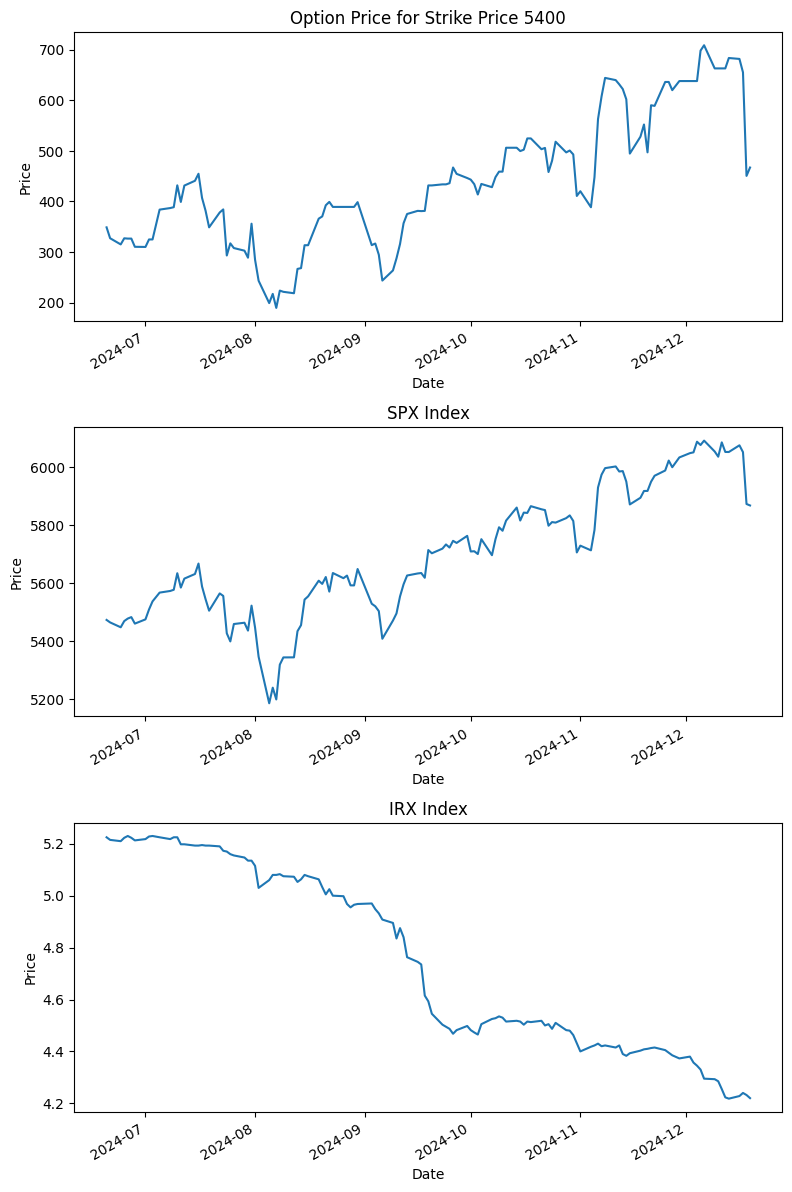

In [7]:
# Plot the data

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

final_df.ffill(inplace=True)

K = 5400.0

axes[0].set_ylabel('Price')
axes[1].set_ylabel('Price')
axes[2].set_ylabel('Price')

final_df[K].plot(ax=axes[0], title='Option Price for Strike Price 5400')
final_df['^SPX'].plot(ax=axes[1], title='SPX Index')
final_df['^IRX'].plot(ax=axes[2], title='IRX Index')

plt.tight_layout(pad=1.0)

plt.show()

## **Classical BS model**

The pricing for the call options is given by 

$$
    C(S_0, T) = S_0 N(d_1) - K e^{-r\tau} \cdot N(d_2)
$$
where 
$d_1 = \frac{\ln \left (\frac{S_0}{K} \right ) + (r + \frac{\sigma^2}{2})T}{\sigma \sqrt{T}}$ and $d_2 = d_1 - \sigma \sqrt T$

In [8]:
from scipy.stats import norm

def BS_call_price(S, K, T, t, r, sigma):
    """
    Calculate the Black-Scholes price for a European call option.

    Parameters:
    S (float): Spot price of the underlying asset
    K (float): Strike price of the option
    T (float): Time to maturity (in years)
    r (float): Risk-free interest rate (annualized)
    sigma (float): Volatility of the underlying asset (annualized)

    Returns:
    float: Black-Scholes call option price
    """
    T = T - t
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [9]:
# Calibrate volatility from the 
# first option chain data



def BS_call_error(S, K, T, t, r, sigma, C):
    return (BS_call_price(S, K, T, t, r, sigma) - C)**2

def BS_call_calibration(sigma):
    global S, T, r, options

    error = 0
    for k, c in options.items():
        error += BS_call_error(S, k, T, 0, r, sigma, c)**2
    return error


from scipy.optimize import minimize

T = ((pd.to_datetime(maturity_24) - final_df.index[0]).days)/365
r = final_df['^IRX'].iloc[0]/100
S = final_df['^SPX'].iloc[0]

temp = calls_df_24.iloc[0].dropna()[:-2]

options = {temp.index[i]: temp.values[i] for i in range(len(temp))}

result = minimize(BS_call_calibration, 0.2, method='CG', bounds=[(0.001, 1.0)])
sigma = result.x[0]

print(sigma)


C:\Users\santo\AppData\Local\Temp\ipykernel_13552\1031152679.py:28: RuntimeWarning: Method CG cannot handle bounds.
  result = minimize(BS_call_calibration, 0.2, method='CG', bounds=[(0.001, 1.0)])


0.13594008521941792


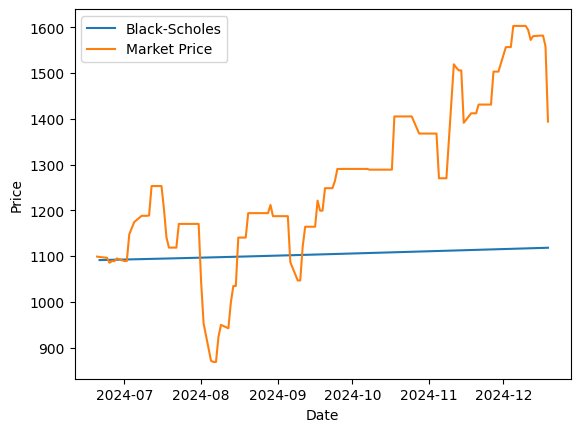

In [10]:
BS_call_prices = []

K = 4500.0

ITM_option = final_df[K]
ITM_option.ffill(inplace=True)

for i in range(1, len(ITM_option.index)):
    d = ITM_option.index[i]
    t = T-((pd.to_datetime(maturity_24) - d).days)/365
    s = final_df['^SPX'].iloc[i-1]
    BS_call_prices.append(BS_call_price(S*np.exp(r*t), K, T, t, r, sigma))


plt.plot(ITM_option.index[1:], BS_call_prices, label='Black-Scholes')
plt.plot(ITM_option, label='Market Price')

plt.legend(['Black-Scholes', 'Market Price'])

plt.xlabel('Date')
plt.ylabel('Price')

plt.show()

In [11]:
error = np.mean(np.abs(np.array(BS_call_prices) - np.array(ITM_option[1:]))**2)
print(error)

53707.9923043687


## fractional Black-Scholes model

In [12]:
import numpy as np
from scipy.stats import norm

def fBS_call_price(S, K, T, t, r, sigma, H):
    """
    Calculate the price of a European call option under the fractional Black-Scholes model.

    Parameters:
        S (float): Current stock price.
        K (float): Strike price.
        T (float): Time to maturity (in years).
        t (float): Current time (in years).
        r (float): Risk-free interest rate.
        sigma (float): Volatility.
        H (float): Hurst parameter (0 < H < 1).

    Returns:
        float: Price of the call option.
    """
    # Time difference
    tau = T - t
    if tau <= 0:
        return max(S - K, 0)  # Handle expiry case

    # Adjusted volatility term
    sigma_adj = sigma * np.sqrt((T**(2 * H) - t**(2 * H)) / (2 * H))

    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma_adj**2) * tau) / (sigma_adj * np.sqrt(tau))
    d2 = d1 - sigma_adj * np.sqrt(tau)

    # Calculate the call price
    call_price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    return call_price

def fBS_call_price_error(params):
    """
    Computes the squared error between model prices and observed market prices.

    Parameters:
        params: List containing [sigma, H].

    Returns:
        float: Sum of squared errors.
    """
    sigma, H = params
    global S, T, r, options

    error = 0
    for K, C in options.items():
        model_price = fBS_call_price(S, K, T, 0, r, sigma, H)  # t=0 at valuation
        error += (model_price - C)**2
    return error

result = minimize(fBS_call_price_error,
    [0.1, 0.5],
    method='L-BFGS-B',
    bounds=[(0.01, 1.0), (0.001, 0.99)]
    )

sigma, H = result.x
print(sigma, H)

0.1745766975885543 0.46026106051101445


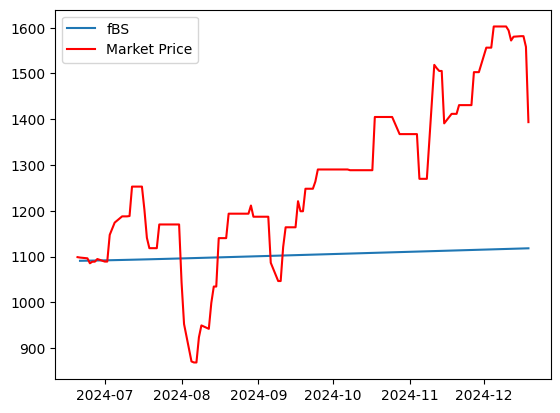

53718.94259287689


In [13]:
fBS_call_prices = []

for i in range(1, len(ITM_option.index)):
    d = ITM_option.index[i]
    t = T-((pd.to_datetime(maturity_24) - d).days)/365
    s = final_df['^SPX'].iloc[i-1]
    fBS_call_prices.append(fBS_call_price(S*np.exp(r*t), K, T, t, r, sigma, H))

plt.plot(ITM_option.index[1:], fBS_call_prices, label='Black-Scholes')
plt.plot(ITM_option.index, ITM_option, label='Market Price', color='red')
# plt.plot(ITM_option.index[1:], BS_call_prices, color='green')

plt.legend(['fBS', 'Market Price', "BS"])

plt.show()

error = np.mean(np.abs(np.array(fBS_call_prices) - np.array(ITM_option[1:]))**2)

print(error)

## **Multifractional Brownian Motion**

In [36]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
from scipy.stats import norm  # Import norm for CDF

# Define the Hurst exponent function (sinusoidal)
def h(t, A, B, C, D):
    return A * np.cos(B * t + C) + D

# Multifractional Black-Scholes Call price formula
def mBS_call(S0, K, T, r, sigma, H_params):
    A, B, C, D = H_params
    H_T = h(T, A, B, C, D)
    variance = sigma**2 * T**(2 * H_T)
    d1 = (np.log(S0 / K) + r * T + 0.5 * variance) / np.sqrt(variance)
    d2 = d1 - np.sqrt(variance)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Objective function to minimize (sum of squared errors)
def objective(params, S0, K, T_values, r, market_prices):
    A, B, C, D, sigma = params
    H_params = (A, B, C, D)
    model_prices = [mBS_call(S0, K, T, r, sigma, H_params) for T in T_values]
    return np.array(model_prices) - np.array(market_prices)


# Initial parameter guesses (A, B, C, D, sigma)
initial_guess = [0.1, 2 * np.pi, 0.0, 0.5, 0.2]

# Bounds for parameters
bounds = (
    [0, 0.01, 0, 0.3, 0],  # Lower bounds
    [0.8, np.inf, np.pi, 1, np.inf]  # Upper bounds
)

S0 = S

maturity_date = pd.to_datetime(maturity_24)

T_values = (maturity_date- ITM_option.index).days /365
market_prices = ITM_option


# Calibrate parameters using least squares

result = least_squares(
        objective,
        initial_guess,
        args=(S0, K, T_values, r, market_prices),
        bounds=bounds
    )

# Extract and print estimated parameters
A_opt, B_opt, C_opt, D_opt, sigma_opt = result.x
mse = np.mean(result.fun**2)

print("Calibrated Parameters:")
print(f"A (amplitude): {A_opt:.4f}")
print(f"B (frequency): {B_opt:.4f}")
print(f"C (phase shift): {C_opt:.4f}")
print(f"D (vertical shift): {D_opt:.4f}")
print(f"σ (volatility): {sigma_opt:.4f}")
print(f"MSE: {mse:.4f}")

Calibrated Parameters:
A (amplitude): 0.8000
B (frequency): 4.9177
C (phase shift): 2.9356
D (vertical shift): 0.7585
σ (volatility): 0.4305
MSE: 6348.1642


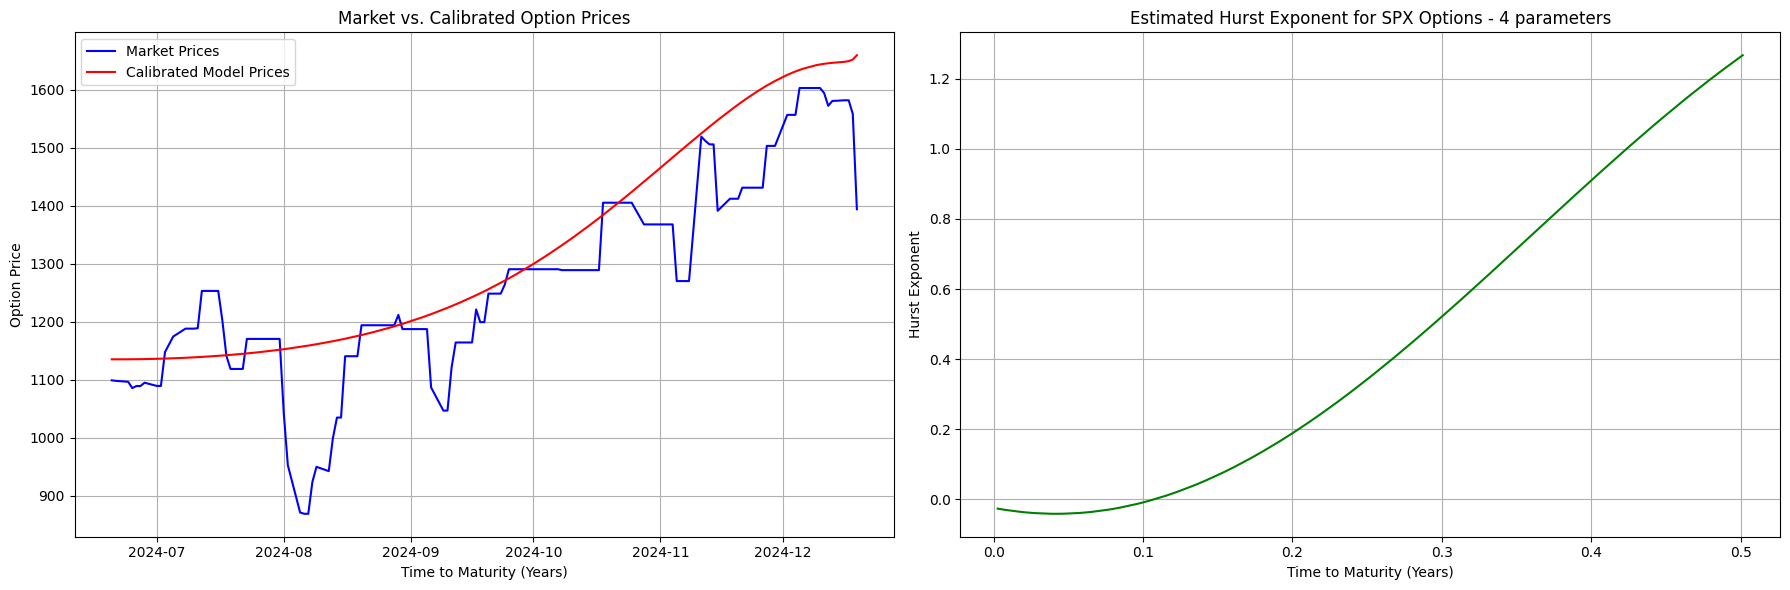

In [37]:
# Calculate option values using the calibrated parameters
calibrated_params = [A_opt, B_opt, C_opt, D_opt, sigma_opt]

T = T_values[0]
# Calculate option values for each time to maturity in T_values
calculated_option_values = [
    mBS_call(S0*np.exp(r*(T-t)), K, t, r, sigma_opt, calibrated_params[:4]) for t in T_values
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot market prices and calibrated model prices
ax1.plot(ITM_option, label="Market Prices", color='blue')
ax1.plot(ITM_option.index, calculated_option_values, label="Calibrated Model Prices", color='red')
ax1.set_xlabel("Time to Maturity (Years)")
ax1.set_ylabel("Option Price")
ax1.set_title("Market vs. Calibrated Option Prices")
ax1.legend()
ax1.grid()

# Plot estimated Hurst exponent
ax2.plot(T_values, [h(T, A_opt, B_opt, C_opt, D_opt) for T in T_values], color='green')
ax2.set_xlabel("Time to Maturity (Years)")
ax2.set_ylabel("Hurst Exponent")
ax2.set_title("Estimated Hurst Exponent for SPX Options - 4 parameters")
ax2.grid()

plt.tight_layout()
plt.show()

## **Fractional Heston Model**